In [1]:
import PythonicDISORT
from PythonicDISORT.subroutines import _compare
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import pi

Previously saved reference solutions will be loaded if F2PY-wrapped Stamnes' DISORT is unavailable.

In [2]:
disort_is_installed = True
try:
    import disort
except ImportError:
    disort_is_installed = False

# Table of Contents
* [4a and setup](#4a-and-setup)
* [4b](#4b)
* [4c](#4c)


# Test Problem 4:  Haze-L Scattering, Beam Source

The *haze-L phase function* models a hazy sky. Its Legendre coefficients are taken from Garcia, R.D.M. and C.E. Siewert, 1985: *Benchmark Results in Radiative Transfer, Transport Theory and Statistical Physics* 14, 437-483. The corresponding atmospheric optical depth (`tau_arr`) should be around $1$ -- thicker than that of clear sky but thinner than that of a typical cloud -- though the test problems are not intended to serve as realistic models.

Results can be compared to Tables 12 to 16 of Garcia and Siewert, 1985. The intensity field of the upwelling radiation, which can be compared to satellite measurements, is plotted for each subproblem.

# 4a and setup

**PythonicDISORT**

In [3]:
Leg_coeffs_ALL = np.array([1,
                           2.41260, 3.23047, 3.37296, 3.23150, 2.89350, 
                           2.49594, 2.11361, 1.74812, 1.44692, 1.17714,
                           0.96643, 0.78237, 0.64114, 0.51966, 0.42563,
                           0.34688, 0.28351, 0.23317, 0.18963, 0.15788,
                           0.12739, 0.10762, 0.08597, 0.07381, 0.05828,
                           0.05089, 0.03971, 0.03524, 0.02720, 0.02451,
                           0.01874, 0.01711, 0.01298, 0.01198, 0.00904,
                           0.00841, 0.00634, 0.00592, 0.00446, 0.00418,
                           0.00316, 0.00296, 0.00225, 0.00210, 0.00160,
                           0.00150, 0.00115, 0.00107, 0.00082, 0.00077,
                           0.00059, 0.00055, 0.00043, 0.00040, 0.00031,
                           0.00029, 0.00023, 0.00021, 0.00017, 0.00015,
                           0.00012, 0.00011, 0.00009, 0.00008, 0.00006,
                           0.00006, 0.00005, 0.00004, 0.00004, 0.00003,
                           0.00003, 0.00002, 0.00002, 0.00002, 0.00001,
                           0.00001, 0.00001, 0.00001, 0.00001, 0.00001,
                           0.00001, 0.00001])
NLeg_all = len(Leg_coeffs_ALL)

######################################### PYDISORT ARGUMENTS #######################################

tau_arr = 1  # One layer of thickness 1 (medium-thick atmosphere)
omega_arr = 1 - 1e-6  # Reduced from 1 (conservative scattering) which is not implemented
NQuad = 32  # 32 streams (16 quadrature nodes for each hemisphere)
Leg_coeffs_all = Leg_coeffs_ALL / (2 * np.arange(NLeg_all) + 1)  # Haze-L phase function
mu0 = 1  # Cosine of solar zenith angle (directly downwards)
I0 = pi  # Intensity of direct beam
phi0 = pi  # Azimuthal angle of direct beam

# Optional (used)
f_arr = Leg_coeffs_all[NQuad]  # For delta-M scaling (improves accuracy, especially for fluxes)
NT_cor = True  # Turn on NT corrections (improves accuracy of intensity field; no effect on fluxes)

# Optional (unused)
NLeg = None
NLoops = None
b_pos = 0
b_neg = 0
only_flux = False
BDRF_Fourier_modes = []
s_poly_coeffs = np.array([[]])
use_banded_solver_NLayers=10
autograd_compatible=False

####################################################################################################

Naturally, the haze-L phase function models haze scattering better than the Henyey-Greenstein phase function of the same asymmetry parameter $g$, though the former still contains several assumptions particularly that of spherical particles. The following plot compares the two phase functions, observe that the haze-L phase function varies more and is more detailed.

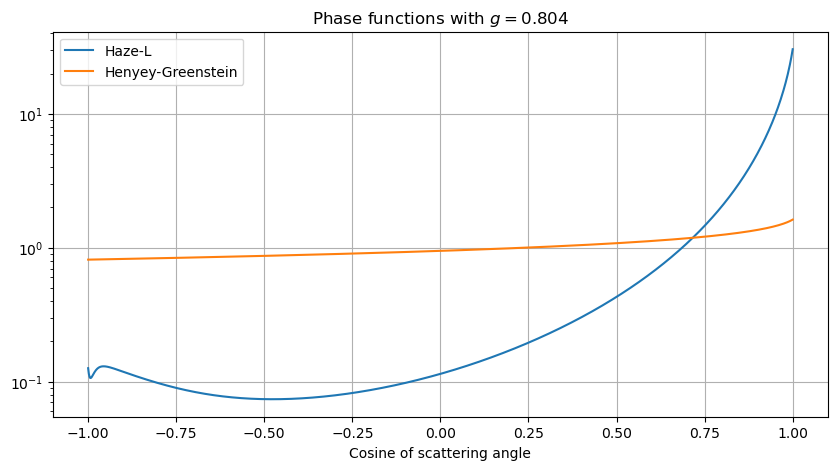

In [4]:
# Plots of anisotropic phase functions (irrelevant to calling pydisort)
Nnu = 1000
nu = np.linspace(-1, 1, Nnu)
g = Leg_coeffs_ALL[1] / 3

plt.figure(figsize=(10, 5))
plt.semilogy(nu, np.polynomial.legendre.Legendre(Leg_coeffs_ALL)(nu), label="Haze-L")
plt.semilogy(
    nu,
    np.polynomial.legendre.Legendre(
        g ** np.arange(NLeg_all) / (2 * np.arange(NLeg_all) + 1)
    )(nu),
    label="Henyey-Greenstein",
)
plt.legend()
plt.title(r"Phase functions with $g =$" + str(np.round(g, 3)))
plt.xlabel("Cosine of scattering angle")
plt.grid()

In [5]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all[: NQuad + 1], # For this test, DISORT strangely does not use all the moments
    mu0, I0, phi0,
    f_arr=f_arr,
    NT_cor=NT_cor
)

**Setup for tests**

In [6]:
# Reorder mu_arr from smallest to largest
reorder_mu = np.argsort(mu_arr)
mu_arr_RO = mu_arr[reorder_mu]

# We may not want to compare intensities around the direct beam
deg_around_beam_to_not_compare = 0
mu_to_compare = (
    np.abs(np.arccos(np.abs(mu_arr_RO)) - np.arccos(mu0)) * 180 / pi
    > deg_around_beam_to_not_compare
)
mu_test_arr_RO = mu_arr_RO[mu_to_compare]

In [7]:
# Number of phi grid points
Nphi = 2
phi_arr = np.random.random(Nphi) * 2 * pi

# tau test points
tau_test_arr = np.array([0, 0.5, 1])
Ntau = len(tau_test_arr)

**Stamnes' DISORT**

In [8]:
# Stamnes' DISORT arguments
nlyr = 1
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = tau_arr
ssalb = omega_arr
pmom = Leg_coeffs_all.T[: NQuad + 1] # For this test, DISORT strangely does not use all the moments
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 0
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [9]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    results = np.load("Stamnes_results/4a_test.npz")
    # Load saved results from Stamnes' DISORT
    uu = results["uu"]
    flup = results["flup"]
    rfldn = results["rfldn"]
    rfldir = results["rfldir"]
    # Load comparison points
    tau_test_arr = results["tau_test_arr"]
    phi_arr = results["phi_arr"]

**Comparisons**

In [10]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 1.443120262158662e-05
Difference ratio = 1.0000000053711795

Downward (diffuse) fluxes
Difference = 1.4633815635045622e-05
Difference ratio = 8.073274968088223e-06

Direct (downward) fluxes
Difference = 1.3307408042173563e-07
Difference ratio = 6.98378420884403e-08

Intensities

At tau = 1.0
Max pointwise difference = 2.993973468341793e-05
At tau = 0.0
Max pointwise difference ratio = 0.0003987246265106425



**Does the test pass?**

In [11]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/4a_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [12]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

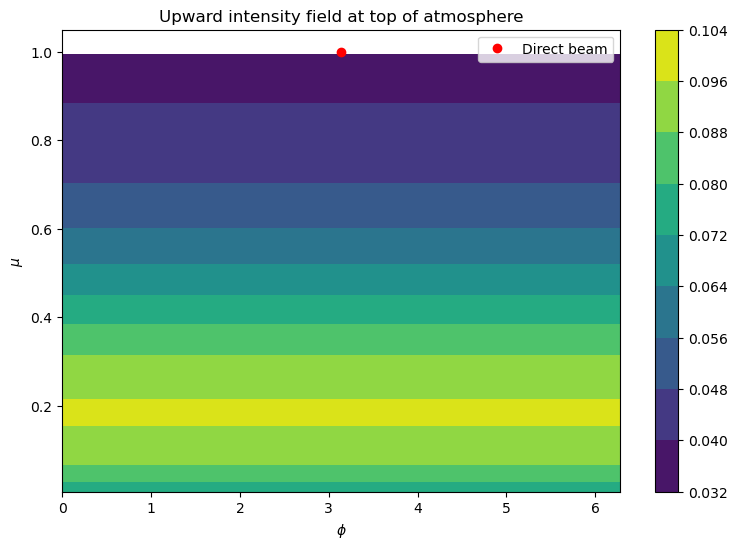

In [13]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.plot(phi0, mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)
plt.legend()

----------

# 4b

**PythonicDISORT**

In [14]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = 1
omega_arr = 0.9
NQuad = 32
Leg_coeffs_all = Leg_coeffs_ALL / (2 * np.arange(83) + 1)
mu0 = 1
I0 = pi
phi0 = pi

# Optional (used)
f_arr = Leg_coeffs_all[NQuad]
NT_cor = True

# Optional (unused)
NLeg=None
NLoops=None
b_pos=0
b_neg=0
only_flux=False
BDRF_Fourier_modes=[]
s_poly_coeffs=np.array([[]])
use_banded_solver_NLayers=10
autograd_compatible=False

####################################################################################################

In [15]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all[: NQuad + 1], # For this test, DISORT strangely does not use all the moments
    mu0, I0, phi0,
    f_arr=f_arr,
    NT_cor=NT_cor
)

**Stamnes' DISORT**

In [16]:
# tau test points
tau_test_arr = np.array([0, 0.5, 1])
Ntau = len(tau_test_arr)

In [17]:
# Stamnes' DISORT arguments
nlyr = 1
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = tau_arr
ssalb = omega_arr
pmom = Leg_coeffs_all.T[: NQuad + 1] # For this test, DISORT strangely does not use all the moments
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 0
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [18]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    results = np.load("Stamnes_results/4b_test.npz")
    # Load saved results from Stamnes' DISORT
    uu = results["uu"]
    flup = results["flup"]
    rfldn = results["rfldn"]
    rfldir = results["rfldir"]
    # Load comparison points
    tau_test_arr = results["tau_test_arr"]
    phi_arr = results["phi_arr"]

**Comparisons**

In [19]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 1.3204732596250324e-07
Difference ratio = 1.1149317382698487e-06

Downward (diffuse) fluxes
Difference = 2.3841857896204775e-06
Difference ratio = 1.9459678150507376e-06

Direct (downward) fluxes
Difference = 1.3307408042173563e-07
Difference ratio = 6.98378420884403e-08

Intensities

At tau = 0.5
Max pointwise difference = 3.040340539106623e-06
At tau = 0.0
Max pointwise difference ratio = 6.739560636932136e-06



**Does the test pass?**

In [20]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/4b_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [21]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

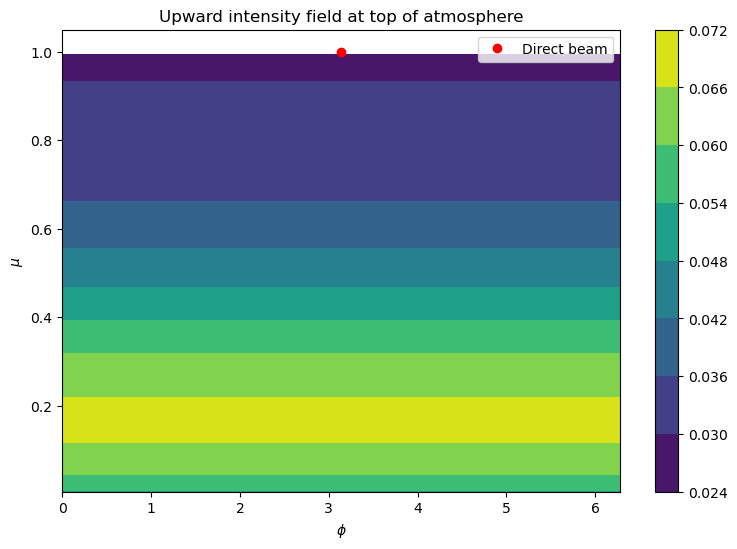

In [22]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.plot(phi0, mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)
plt.legend()

-------

# 4c

**PythonicDISORT**

In [23]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = 1
omega_arr = 0.9
NQuad = 32
Leg_coeffs_all = Leg_coeffs_ALL / (2 * np.arange(83) + 1)
mu0 = 0.5
I0 = pi
phi0 = pi

# Optional (used)
f_arr = Leg_coeffs_all[NQuad]
NT_cor = True

# Optional (unused)
NLeg=None
NLoops=None
b_pos=0
b_neg=0
only_flux=False
BDRF_Fourier_modes=[]
s_poly_coeffs=np.array([[]])
use_banded_solver_NLayers=10
autograd_compatible=False

####################################################################################################

In [24]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all[: NQuad + 1], # For this test, DISORT strangely does not use all the moments
    mu0, I0, phi0,
    f_arr=f_arr,
    NT_cor=NT_cor
)

**Stamnes' DISORT**

In [25]:
# tau test points
tau_test_arr = np.array([0, 0.5, 1])
Ntau = len(tau_test_arr)

In [26]:
# Stamnes' DISORT arguments
nlyr = 1
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = tau_arr
ssalb = omega_arr
pmom = Leg_coeffs_all.T[: NQuad + 1] # For this test, DISORT strangely does not use all the moments
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 0
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [27]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    results = np.load("Stamnes_results/4c_test.npz")
    # Load saved results from Stamnes' DISORT
    uu = results["uu"]
    flup = results["flup"]
    rfldn = results["rfldn"]
    rfldir = results["rfldir"]
    # Load comparison points
    tau_test_arr = results["tau_test_arr"]
    phi_arr = results["phi_arr"]

**Comparisons**

In [28]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 2.0448570800524202e-07
Difference ratio = 9.068618212030869e-07

Downward (diffuse) fluxes
Difference = 5.960464467075457e-07
Difference ratio = 0.9999999982444983

Direct (downward) fluxes
Difference = 4.371139006309477e-08
Difference ratio = 3.1740779073332835e-08

Intensities

At tau = 0.5
Max pointwise difference = 1.1528905629887287e-06
At tau = 0.5
Max pointwise difference ratio = 2.4825320794279057e-05



**Does the test pass?**

In [29]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/4c_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [30]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

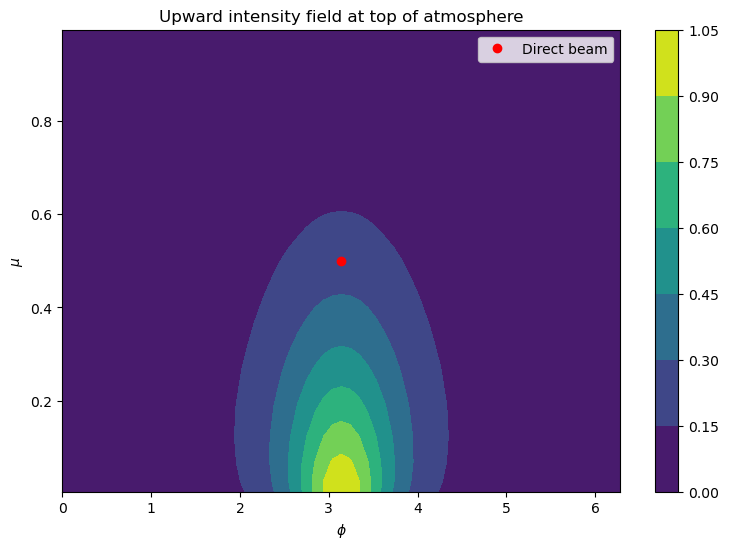

In [31]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.plot(phi0, mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)
plt.legend()

-------